In [ ]:
mport numpy as np
import pandas as pd

In [ ]:

df = pd.read_csv('/content/train_all_tasks.csv')
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


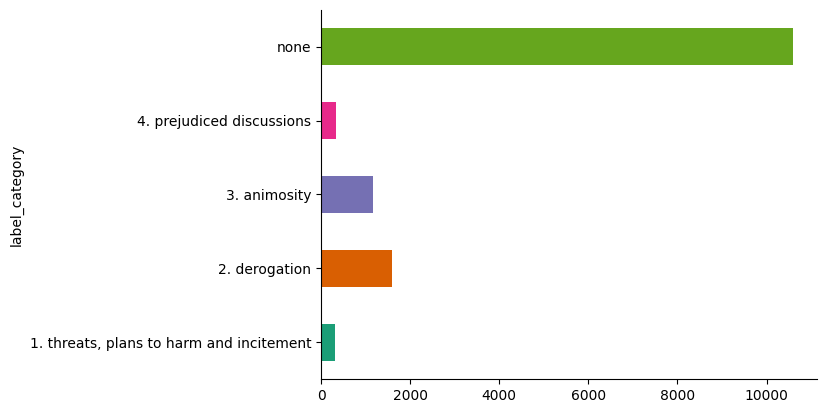

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import tensorflow, nltk, re, warnings
warnings.filterwarnings('ignore')
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Pre-Processing

In [ ]:
df.isnull().sum()

rewire_id         0
text              0
label_sexist      0
label_category    0
label_vector      0
dtype: int64

Checking for and removing duplicates

In [ ]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(14000, 5)
(14000, 5)


In [ ]:
df['label_category'].value_counts()

label_category
none                                        10602
2. derogation                                1590
3. animosity                                 1165
4. prejudiced discussions                     333
1. threats, plans to harm and incitement      310
Name: count, dtype: int64

In [ ]:
df = df.replace(to_replace = 'none', value = np.NaN)

In [ ]:
df.isnull().sum()

rewire_id             0
text                  0
label_sexist          0
label_category    10602
label_vector      10602
dtype: int64

In [ ]:
df.dropna(subset=['label_category'], inplace=True)

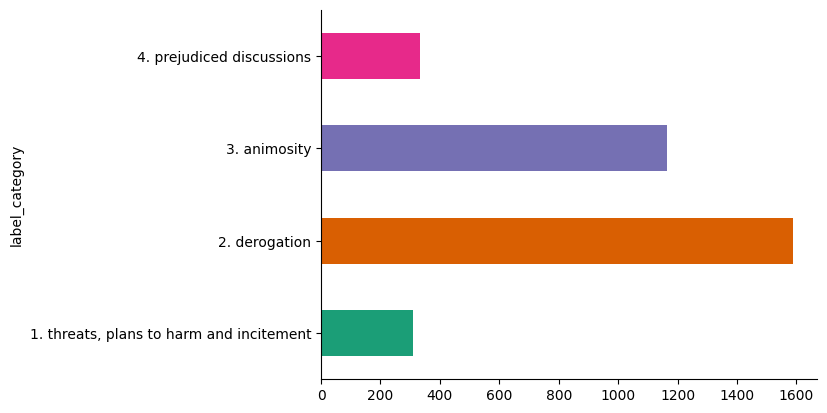

In [ ]:
# @title label_category after handling none

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.isnull().sum()

rewire_id         0
text              0
label_sexist      0
label_category    0
label_vector      0
dtype: int64

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


def preprocess_text(text):

    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)


    tokens = word_tokenize(text)


    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

df['text_processed'] = df['text'].apply(preprocess_text)




In [ ]:
df.head()

,rewire_id,text,label_sexist,label_category,label_vector,text_processed
8,sexism2022_english-10142,"just the inside of your wallet: cash, bank car...",sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...,inside wallet cash bank card credit card debit...
11,sexism2022_english-760,They get the initial chance because they are a...,sexist,2. derogation,2.1 descriptive attacks,get initial chance attractive woman flock see ...
17,sexism2022_english-1108,ugly chicks A pussy is a pussy.,sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...,ugly chick pussy pussy
18,sexism2022_english-10099,fuck her off with a nine mm this is what you g...,sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm,fuck nine mm get arab fuck monkey
19,sexism2022_english-10014,How about I talk shit to an idiot like you? Ar...,sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,...",talk shit idiot like nazi like bitch


In [ ]:
df.dtypes


rewire_id         object
text              object
label_sexist      object
label_category    object
label_vector      object
text_processed    object
dtype: object

In [ ]:
df.drop(columns=['text'], inplace=True)


In [ ]:
df['label_category'].value_counts()

label_category
2. derogation                               1590
3. animosity                                1165
4. prejudiced discussions                    333
1. threats, plans to harm and incitement     310
Name: count, dtype: int64

Text(0.5, 1.0, 'The distribution of positive and negative reviews')

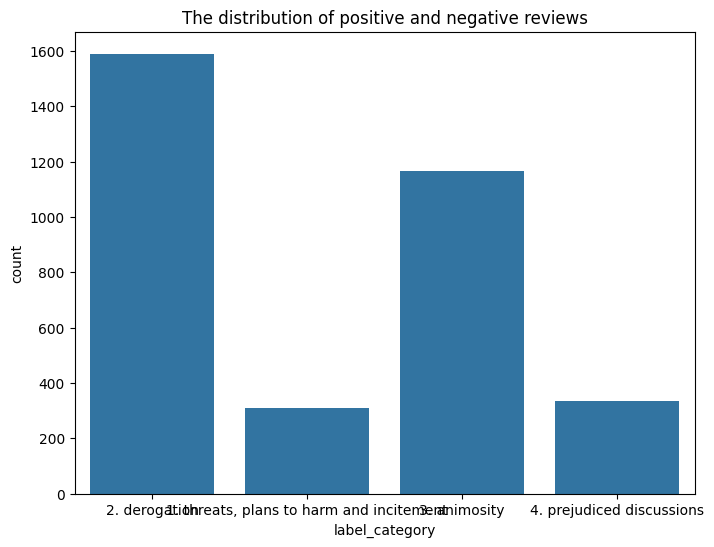

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df, x="label_category")
plt.title('The distribution of positive and negative reviews')

# Train Test Split and SMOTE

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


X = df['text_processed']
y = df['label_category']
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


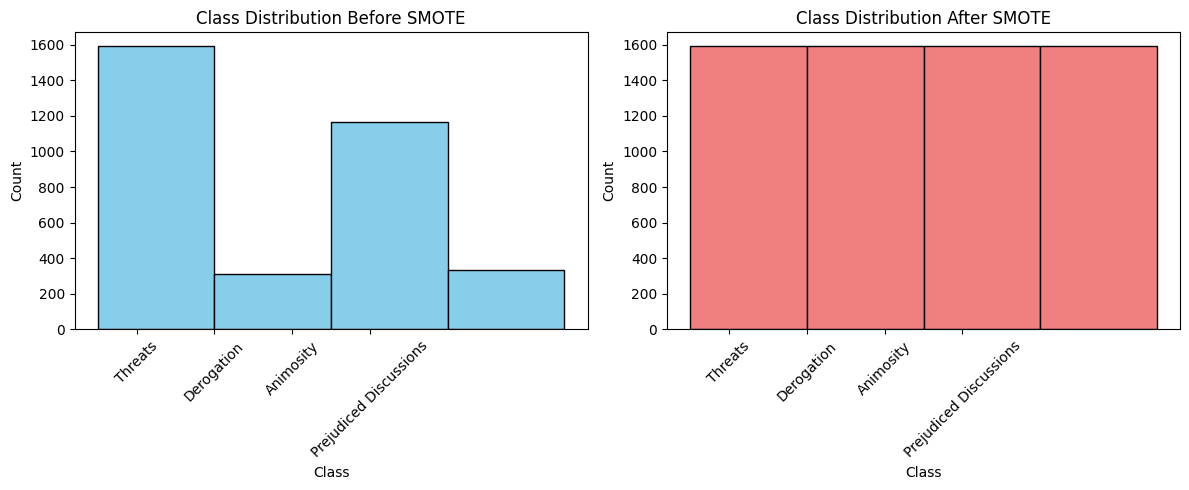

In [ ]:
import matplotlib.pyplot as plt

labels = ['Threats', 'Derogation', 'Animosity', 'Prejudiced Discussions']


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y, bins=4, color='skyblue', edgecolor='black')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0.25, 0.75, 1.25, 1.75], labels, rotation=45)


plt.subplot(1, 2, 2)
plt.hist(y_resampled, bins=4, color='lightcoral', edgecolor='black')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0.25, 0.75, 1.25, 1.75], labels, rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()


all_labels = y_train.tolist() + y_test.tolist()


label_encoder.fit(all_labels)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Label Mapping:")
print(label_mapping)


Class Label Mapping:
{'1. threats, plans to harm and incitement': 0, '2. derogation': 1, '3. animosity': 2, '4. prejudiced discussions': 3}


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping


X_train, X_test, y_train, y_test = train_test_split(df['text_processed'], df['label_category'], test_size=0.3, random_state=42, stratify=df['label_category'])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)


max_sequence_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


label_mapping = {'1. threats, plans to harm and incitement': 0, '2. derogation': 1, '3. animosity': 2, '4. prejudiced discussions': 3}

y_train_encoded = np.array(y_train.map(lambda x: label_mapping[x]))
y_test_encoded = np.array(y_test.map(lambda x: label_mapping[x]))



def create_bi_lstm_model(vocab_size, embedding_dim, max_sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(Bidirectional(LSTM(units=128)))
    model.add(Dense(units=1, activation='sigmoid'))
    return model


embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
bi_lstm_model = create_bi_lstm_model(vocab_size, embedding_dim, max_sequence_length)
bi_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = bi_lstm_model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

loss, accuracy = bi_lstm_model.evaluate(X_test_padded, y_test_encoded)
print("Test Accuracy:", accuracy)



Epoch 1/10
60/60 [==============================] - 71s 400ms/step - loss: 0.0000e+00 - accuracy: 0.4648 - val_loss: 0.0000e+00 - val_accuracy: 0.4664
Epoch 2/10
60/60 [==============================] - 25s 422ms/step - loss: 0.0000e+00 - accuracy: 0.4685 - val_loss: 0.0000e+00 - val_accuracy: 0.4664
Epoch 3/10
60/60 [==============================] - 24s 389ms/step - loss: 0.0000e+00 - accuracy: 0.4685 - val_loss: 0.0000e+00 - val_accuracy: 0.4664
Epoch 4/10
32/32 [==============================] - 4s 135ms/step - loss: 0.0000e+00 - accuracy: 0.4676
Test Accuracy: 0.4676470458507538


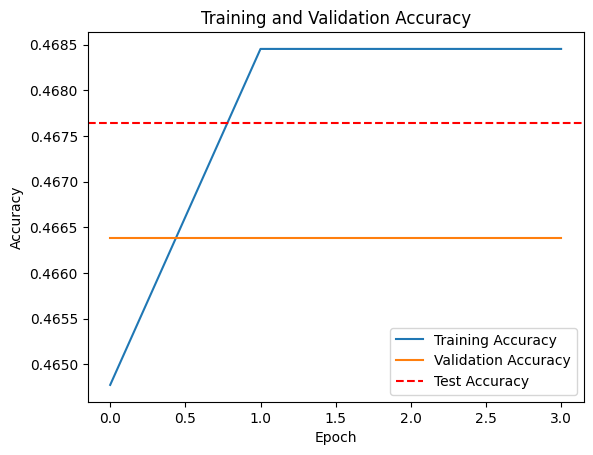

In [ ]:
import matplotlib.pyplot as plt

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']


plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.axhline(y=accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


32/32 [==============================] - 4s 96ms/step
Confusion Matrix:
[[  0  93   0   0]
 [  0 477   0   0]
 [  0 350   0   0]
 [  0 100   0   0]]


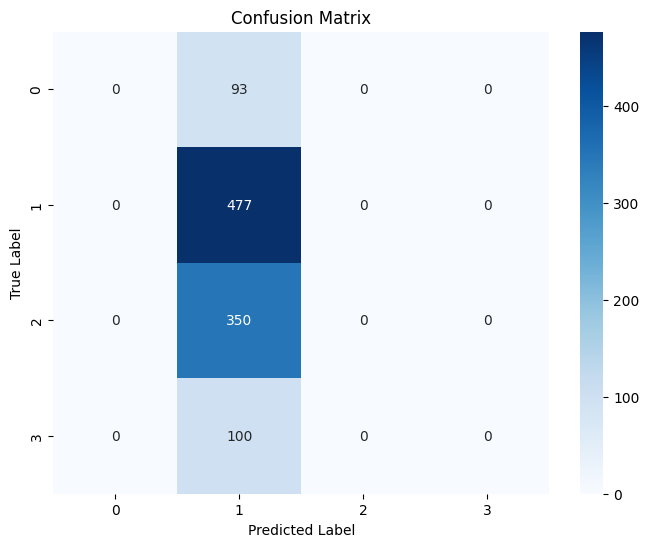

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.47      1.00      0.64       477
           2       0.00      0.00      0.00       350
           3       0.00      0.00      0.00       100

    accuracy                           0.47      1020
   macro avg       0.12      0.25      0.16      1020
weighted avg       0.22      0.47      0.30      1020



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_prob = bi_lstm_model.predict(X_test_padded)

y_pred = (y_pred_prob > 0.5).astype(int).flatten()


y_pred = y_pred[:len(y_test_encoded)]


conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))



